In [8]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
# Standard imports
import pandas as pd
import numpy as np
import re
import pickle
import string

# Visualization library
import seaborn as sns
import matplotlib.pyplot as plt

# NLP library
from nltk.tokenize import word_tokenize


In [2]:
from numpy.random import seed
seed(42)

In [3]:
df = pd.read_csv('./data/EngSpa.csv')

In [4]:
df.head()

,Unnamed: 0,eng,spa,eng_len,spa_len
0,15828,a dog has four legs,un perro tiene cuatro patas,19,27
1,15829,a lion is an animal,un león es un animal,19,20
2,15830,a noise woke her up,un ruido la despertó,19,20
3,15831,a nurse wears white,una enfermera se viste de blanco,19,32
4,15832,a truck hit the dog,un camión atropelló al perro,19,28


In [5]:
df.drop(columns=['Unnamed: 0', 'eng_len', 'spa_len'], inplace=True)
df.head()

,eng,spa
0,a dog has four legs,un perro tiene cuatro patas
1,a lion is an animal,un león es un animal
2,a noise woke her up,un ruido la despertó
3,a nurse wears white,una enfermera se viste de blanco
4,a truck hit the dog,un camión atropelló al perro


In [6]:
#Converting to list for the model
data = df.values.tolist()

# Examining the first 5 rows
data[:5]

[['a dog has four legs', 'un perro tiene cuatro patas'],
 ['a lion is an animal', 'un león es un animal'],
 ['a noise woke her up', 'un ruido la despertó'],
 ['a nurse wears white', 'una enfermera se viste de blanco'],
 ['a truck hit the dog', 'un camión atropelló al perro']]

In [7]:
# Building empty lists to hold sentences
input_docs = []
target_docs = []
# Building empty vocabulary sets
input_tokens = set()
target_tokens = set()

# Setting the amount of data points to use
n = 15000

for line in data[:n]:
    # Defining an input document and a target document
    input_doc, target_doc = line[0], line[1]
    
    # Appending each input sentence to input_docs
    input_docs.append(input_doc)
    
    # Formatting target documents
    # Splitting words from punctuation  
    target_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", target_doc))
    # Adding <START> and <END> tags
    target_doc = '<START> ' + target_doc + ' <END>'
    # Appending each formated target to target documents
    target_docs.append(target_doc)
  
    # Splitting each sentence into words and adding to vocabulary
    for token in re.findall(r"[\w']+|[^\s\w]", input_doc):
        if token not in input_tokens:
            input_tokens.add(token)
    
    for token in target_doc.split():
        if token not in target_tokens:
            target_tokens.add(token)

In [8]:
print(input_docs[0])
print(target_docs[0])

a dog has four legs
<START> un perro tiene cuatro patas <END>


In [9]:
# Creating a sorted list of all input tokens and target tokens
input_tokens = sorted(list(input_tokens))
target_tokens = sorted(list(target_tokens))

# Saving the length of vocabulary sets as variables. Encoder and Decoder
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)

# Finding the maximum length of an input sentence and target sentence
max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in input_docs])
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in target_docs])

In [10]:
# Print some key dimensions - these need to be used later for enabling model-continued training as well as getting translations
print(f'Number of Encoder Tokens: {num_encoder_tokens}')
print(f'Number of Decoder Tokens: {num_decoder_tokens}')
print(f'Maximum Encoder Sequence Length: {max_encoder_seq_length}')
print(f'Maximum Decoder Sequence Length: {max_decoder_seq_length}')

Number of Encoder Tokens: 4693
Number of Decoder Tokens: 7391
Maximum Encoder Sequence Length: 7
Maximum Decoder Sequence Length: 16


In [11]:
# Creating four dictionaries
input_features_dict = dict(
    [(token, i) for i, token in enumerate(input_tokens)])
target_features_dict = dict(
    [(token, i) for i, token in enumerate(target_tokens)])

# Creating the reverse 
reverse_input_features_dict = dict(
    (i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict(
    (i, token) for token, i in target_features_dict.items())

In [12]:
import pickle

with open('./data/rtfd.p', 'wb') as fp:
    pickle.dump(reverse_target_features_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('./data/tfd.p', 'wb') as fp:
    pickle.dump(target_features_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('./data/rifd.p', 'wb') as fp:
    pickle.dump(reverse_input_features_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('./data/ifd.p', 'wb') as fp:
    pickle.dump(input_features_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
# Checking English index and word dictionary
first2pairs = {k: reverse_input_features_dict[k] for k in list(reverse_input_features_dict)[:2]}
first2pairs

{0: 'a', 1: 'aback'}

In [14]:
# Checking English word and index dictionary
first2pairs = {k: input_features_dict[k] for k in list(input_features_dict)[:2]}
first2pairs

{'a': 0, 'aback': 1}

In [15]:
# Checking Spanish index and word dictionary
firstfewpairs = {k: reverse_target_features_dict[k] for k in list(reverse_target_features_dict)[2:8]}
firstfewpairs

{2: 'a',
 3: 'abajo',
 4: 'abandona',
 5: 'abandonada',
 6: 'abandonado',
 7: 'abandonamos'}

In [16]:
# Checking Spanish word and index dictionary
firstfewpairs = {k: target_features_dict[k] for k in list(target_features_dict)[2:8]}
firstfewpairs

{'a': 2,
 'abajo': 3,
 'abandona': 4,
 'abandonada': 5,
 'abandonado': 6,
 'abandonamos': 7}

In [17]:
# Creating empty matricies for input data
encoder_input_data = np.zeros(
    (len(input_docs), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [18]:
print(f'Encoder Input Data Shape: {encoder_input_data.shape}')
print(f'Decoder Input Data Shape: {decoder_input_data.shape}')
print(f'Decoder Target Data Shape: {decoder_target_data.shape}')

Encoder Input Data Shape: (15000, 7, 4693)
Decoder Input Data Shape: (15000, 16, 7391)
Decoder Target Data Shape: (15000, 16, 7391)


In [19]:
# This block of code sets up our data for input to the neural net.

for line, (input_doc, target_doc) in enumerate(zip(input_docs, target_docs)):

    for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
        # Assigning 1.0 for the current line, timestep, & word in encoder_input_data:
        encoder_input_data[line, timestep, input_features_dict[token]] = 1.0
        # Potential Conditional Statement

    for timestep, token in enumerate(target_doc.split()):
        # Assigning 1.0 for same in decoder_input_data
        decoder_input_data[line, timestep, target_features_dict[token]] = 1.0
        if timestep > 0:
            
            # Setting the decoder target data for 1 previous timestep
            decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1.0

In [20]:
#Checking sample word in matrix
np.argmax(encoder_input_data[1])

0

In [21]:
#Confirming word was read correctly
reverse_input_features_dict[0]

'a'

In [22]:
print(num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length)

4693 7391 7 16


## LSTM MODEL BUILD TO START FROM HERE

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Masking
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.backend import manual_variable_initialization #was added to ensure model can be loaded correctly later
manual_variable_initialization(True)

import os

In [24]:
tf.random.set_seed(42)

## Defining the model Structure

In [25]:
#Defining the model structure
latent_dim = 256 ### Would have liked to increase this, but memory and run-time issues caused me to cap

# Encoder training setup
encoder_inputs = Input(shape=(None, num_encoder_tokens))

encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs) 
encoder_states = [state_h, state_c]

# Decoder training setup:
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,_ ,_ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

## Model training starts here

In [26]:
epochs = 5
batch_size = 128

#callback = EarlyStopping(monitor='val_accuracy', patience=4) #Was turned off since model was improving gradually

training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

training_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'], sample_weight_mode='temporal')

#Turn checkpoint on so that interim model run results can be used if system crashes, saved every 5 epochs
model_checkpoint= ModelCheckpoint('./models/endspan{epoch:02d}.h5',period=5,save_weights_only=False)

history = training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, 
                    batch_size = batch_size, 
                    epochs = epochs, 
                    callbacks=[model_checkpoint],         
                    validation_split = 0.2)
                    #callbacks = callback)


Epoch 1/5
94/94 [==============================] - 178s 2s/step - loss: 2.2564 - accuracy: 0.6855 - val_loss: 2.2001 - val_accuracy: 0.7085
Epoch 2/5
94/94 [==============================] - 182s 2s/step - loss: 2.0024 - accuracy: 0.7317 - val_loss: 2.2051 - val_accuracy: 0.7088
Epoch 3/5
94/94 [==============================] - 178s 2s/step - loss: 1.9820 - accuracy: 0.7317 - val_loss: 2.2219 - val_accuracy: 0.7095
Epoch 4/5
94/94 [==============================] - 148s 2s/step - loss: 1.9654 - accuracy: 0.7317 - val_loss: 2.2060 - val_accuracy: 0.7095
Epoch 5/5
49/94 [==============>...............] - ETA: 1:03 - loss: 1.9471 - accuracy: 0.7314

KeyboardInterrupt: 

In [32]:
#Saving the model so we can use later
training_model.save('./models/training_model_v2.h5')

In [ ]:
epochs = 15
history2 = training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, 
                    batch_size = batch_size, 
                    epochs = epochs, 
                    callbacks=[model_checkpoint],         
                    validation_split = 0.2)
                    #callbacks = callback)


Epoch 1/15
110/110 [==============================] - 210s 2s/step - loss: 1.8267 - accuracy: 0.7531 - val_loss: 2.0642 - val_accuracy: 0.7345
Epoch 2/15
110/110 [==============================] - 205s 2s/step - loss: 1.7936 - accuracy: 0.7578 - val_loss: 2.0325 - val_accuracy: 0.7399
Epoch 3/15
110/110 [==============================] - 208s 2s/step - loss: 1.7630 - accuracy: 0.7620 - val_loss: 2.0236 - val_accuracy: 0.7423
Epoch 4/15
110/110 [==============================] - 207s 2s/step - loss: 1.7362 - accuracy: 0.7648 - val_loss: 1.9959 - val_accuracy: 0.7431
Epoch 5/15
110/110 [==============================] - 206s 2s/step - loss: 1.7094 - accuracy: 0.7672 - val_loss: 1.9748 - val_accuracy: 0.7472
Epoch 6/15
110/110 [==============================] - 211s 2s/step - loss: 1.6820 - accuracy: 0.7706 - val_loss: 1.9661 - val_accuracy: 0.7483
Epoch 7/15
110/110 [==============================] - 206s 2s/step - loss: 1.6555 - accuracy: 0.7737 - val_loss: 1.9460 - val_accuracy: 0.7505

In [32]:
#Saving the model so we can use later
#tf.saved_model.save(training_model, './models/')
training_model.save('training_model_v2.h5')

In [1]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.title('Accuracy');

NameError: name 'plt' is not defined

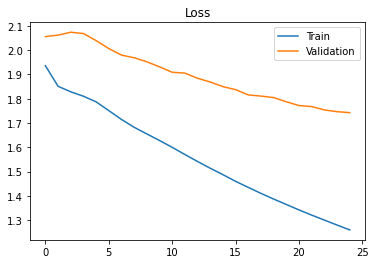

In [34]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.title('Loss');

In [35]:
from tensorflow.keras.models import Model, load_model

training_model = load_model('training_model_v2.h5')

encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]

encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [36]:
def string_to_matrix(user_input):
    '''This function takes in a string and outputs the corresponding matrix'''
    tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
    user_input_matrix = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
    for timestep, token in enumerate(tokens):
        if token in input_features_dict:
            user_input_matrix[0, timestep, input_features_dict[token]] = 1.
    return user_input_matrix

In [37]:
training_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 4428)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 7675)] 0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 4797440     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  8122368     input_2[0][0]                    
                                                                 lstm[0][1]                   

In [22]:
def decode_sequence(test_input):
    '''This function takes in a sentence and returns the decoded sentence'''
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(string_to_matrix(test_input))

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first token of target sequence with the start token.
    target_seq[0, 0, target_features_dict['<START>']] = 1.

    # Sampling loop for a batch of sequences
    decoded_sentence = ''

    stop_condition = False
    while not stop_condition:
        # Run the decoder model to get possible output tokens (with probabilities) & states
        output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)

        # Choose token with highest probability and append it to decoded sentence
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_features_dict[sampled_token_index]
        decoded_sentence += " " + sampled_token

        # Exit condition: either hit max length or find stop token.
        if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [hidden_state, cell_state]

    return decoded_sentence

In [23]:
# Example decoded sentence
decode_sequence('how are you')

NameError: name 'encoder_model' is not defined

In [40]:
# Example decoded sentence
decode_sequence('it is hot today')

' hoy es <END>'

In [42]:
# Example decoded sentence
decode_sequence('i am Shashank')

' estoy estoy <END>'

In [3]:
class Translator:
    '''
    Utilizing the neural network architecture, this class is to translates English to Spanish. 
    '''
    negative_responses = ("no", "nope", "nah", "naw", "not a chance", "sorry")


    exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop", 'end')

    def start_translate(self):
        user_response = input("Hello - what do you want to translate to Spanish?\n")
    
        if user_response.lower() in self.negative_responses:
            print("Ok, have a great day!")
            return
    
        #user_response = input('Great!')
    
        self.translate(user_response)
  
    def translate(self, reply):
        while not self.make_exit(reply):
            reply = input(self.generate_response(reply))
    

    def string_to_matrix(self, user_input):
        tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
        user_input_matrix = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
        for timestep, token in enumerate(tokens):
            if token in input_features_dict:
                user_input_matrix[0, timestep, input_features_dict[token]] = 1.

        return user_input_matrix

    def generate_response(self, user_input):
        input_matrix = self.string_to_matrix(user_input)
        states_value = encoder_model.predict(input_matrix)
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, target_features_dict['<START>']] = 1.0
    
        tran_response = ''

        stop_condition = False

        while not stop_condition:

            output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)

            sampled_token_index = np.argmax(output_tokens[0, -1, :])
            sampled_token = reverse_target_features_dict[sampled_token_index]
            tran_response += " " + sampled_token

            if (sampled_token == '<END>' or len(tran_response) > max_decoder_seq_length):
                stop_condition = True

                target_seq = np.zeros((1, 1, num_decoder_tokens))
                target_seq[0, 0, sampled_token_index] = 1.

            if '<END>' in tran_response:
                tran_response = tran_response.replace('<END>', '')

            punctuations = [' ?', ' .', ' !', ' ,']            
            for punctuation in punctuations:
                if punctuation in tran_response:
                    tran_response = tran_response.replace(punctuation, punctuation[-1])

            states_value = [hidden_state, cell_state]

        return tran_response
  
    def make_exit(self, reply):
        for exit_command in self.exit_commands:
            if exit_command in reply:
                print("Ok, have a great day!")
                return True

In [5]:
# Translate!
translate = Translator()
translate.start_translate()

Hello - what do you want to translate to Spanish?
 Hi


NameError: name 're' is not defined